In [148]:
# Set random seed
seed = 123

# Data manipulation/analysis
import numpy as np
import pandas as pd

# Text preprocessing/analysis
import string
import re
import html
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
#from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, LabelEncoder

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid", context='talk')

In [149]:
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

In [150]:
pd.set_option('max_colwidth',100)

# Read and clean the data

In [151]:
sa_df = pd.read_csv('sentiment_analysis.csv')
sa_df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving pa...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @C...,1


In [152]:
US_Elections_2020 = pd.read_csv('US_Elections_2020.csv')
US_Elections_2020.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months t...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &a...,0,covid19
3,b'Every 107 seconds an American is dying from the #TrumpVirus \n\n#DonaldTrump thinks that is a ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #DiversityandInclusion for all citizens that make our na...,1,NaN


### Replace HTML character codes (&...) with ascii and remove unsupported unicode characters (emoji, etc.)

In [153]:
def clean_html_unicode(text):
    #html code to unicode
    text = html.unescape(text)
    # remove unsupported unicode
    text = text.encode('ascii', 'ignore').decode()
    return text

US_Elections_2020.text = US_Elections_2020.text.apply(clean_html_unicode)
sa_df.text = sa_df.text.apply(clean_html_unicode)

### Remove urls

In [154]:
url_pattern = re.compile(r"(https?://[^\s'\"]+)|(https?[^\s'\"]+)|(\bhtt?[^\s'\"]*\b)")


US_Elections_2020.text = US_Elections_2020.text.str.replace(url_pattern, '')
sa_df.text = sa_df.text.str.replace(url_pattern, '') 

### Capture usernames in a seperate column

In [155]:
user_pattern = re.compile(r"@(\w+)")

US_Elections_2020['userNames'] = US_Elections_2020.text.str.findall(user_pattern)
sa_df['userNames'] = sa_df.text.str.findall(user_pattern)

### Remove usernames and retweet identifer (RT)

In [156]:
user_pattern = re.compile(r"(RT\s)?@(\w+)(:)?\s?")

US_Elections_2020.text = US_Elections_2020.text.str.replace(user_pattern, '')
sa_df.text = sa_df.text.str.replace(user_pattern, '') 

### Remove retweet indentifier

In [157]:
rt_pattern = re.compile(r"\b[rR]{1}[tT]{1}\b")

US_Elections_2020.text = US_Elections_2020.text.str.replace(rt_pattern, '')
sa_df.text = sa_df.text.str.replace(rt_pattern, '') 

### Remove HTML tags

In [158]:
html_pattern = re.compile(r"(?i)(<[^>]+>)")

US_Elections_2020.text = US_Elections_2020.text.str.replace(html_pattern, '')
sa_df.text = sa_df.text.str.replace(html_pattern, '') 

### Remove b'' in US_Elections_2020

In [159]:
b_start = re.compile(r"^(b['\"]?)")
b_end = re.compile(r"(['\"]?)$")

US_Elections_2020.text = US_Elections_2020.text.str.replace(b_start, '')
US_Elections_2020.text = US_Elections_2020.text.str.replace(b_end, '')

### Capture hashtags in a seperate column & create text columns with and without hash tags

In [160]:
hashtag_pattern = re.compile(r"#(\w+)")

US_Elections_2020['hashTags'] = US_Elections_2020.text.str.findall(hashtag_pattern)
sa_df['hashTags'] = sa_df.text.str.findall(hashtag_pattern)

US_Elections_2020['text_wo_ht'] = US_Elections_2020.text.str.replace(hashtag_pattern, '')
sa_df['text_wo_ht'] = sa_df.text.str.replace(hashtag_pattern, '')

#### We have created two new columns: one that only contains hashtags from tweets, and other that contains text without hash tags in it. While buiding the models, the text with Hash tags not removed will be used (only # is removed) beacuse most used hash tags convey the sentiments. (ex: #love, #HBD, etc.)

### Remove punctuation and numbers, covert to lowercase

In [161]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make lower case
    text = text.lower()
    # remove newline character
    text = re.sub(r'\n', ' ', text)

    # remove puctuation
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)

    # remove digits
    text = re.sub(r'\d*', '', text)

    # remove some additional punctuation and non-sensical text
    text = re.sub(r'[‘’“”…]', ' ', text)
    
    # remove extra whitespaces
    text = " ".join(text.split())
    return text

US_Elections_2020.text = US_Elections_2020.text.apply(clean_text)
sa_df.text = sa_df.text.apply(clean_text)

US_Elections_2020.text_wo_ht = US_Elections_2020.text_wo_ht.apply(clean_text)
sa_df.text_wo_ht = sa_df.text_wo_ht.apply(clean_text)

In [162]:
# save df with stop words as pickle file to import and use later
#US_Elections_2020.to_pickle("US_Elections_2020_corpus_with_SW.pkl")
#sa_df.to_pickle("sentiment_analysis_corpus_with_SW.pkl")

### Remove stop words

First, we get the list from nltk corpus. We will extend the list with stopwords provided in the tutorial files.

In [163]:
stop_words = stopwords.words('english')
new_stop_words =  open("stop_words.txt").read().splitlines()
stop_words.extend(new_stop_words)
stop_words = list(set(stop_words))

def remove_stop_words(text):
    strng = ''
    for word in text.split():
        if not word in stop_words:
            strng += word + ' '
    strng = strng.strip()
    return strng

US_Elections_2020.text = US_Elections_2020.text.apply(remove_stop_words)
sa_df.text = sa_df.text.apply(remove_stop_words)

US_Elections_2020.text_wo_ht = US_Elections_2020.text_wo_ht.apply(remove_stop_words)
sa_df.text_wo_ht = sa_df.text_wo_ht.apply(remove_stop_words)

In [164]:
# save df without stop words as a pickle file to use later
#US_Elections_2020.to_pickle("US_Elections_2020_corpus_without_SW.pkl")
#sa_df.to_pickle("sentiment_analysis_corpus_without_SW.pkl")

### sanity check

In [165]:
US_Elections_2020.head()

,text,sentiment,negative_reason,userNames,hashTags,text_wo_ht
0,afraid nov dec jan bidenharris win frump months damage,0,covid19,[robreiner],[BidenHarris2020],afraid nov dec jan win frump months damage
1,lord sumption launches recovery initiative promote anotherway deal covid hysteria rushed laws,0,others,[SueC00K],"[AnotherWay, Covid]",lord sumption launches recovery initiative promote deal hysteria rushed laws
2,uber timing biden advisors pressure brazil sanction gov elected,0,covid19,"[WalidPhares, jairbolsonaro]","[Biden, Brazil]",uber timing advisors pressure sanction gov elected
3,seconds american dying trumpvirus donaldtrump thinks success joebiden,1,NaN,[],"[TrumpVirus, DonaldTrump, JoeBiden]",seconds american dying thinks success
4,democrats embrace diversityandinclusion citizens nation vote,1,NaN,[thewebbix],"[Democrats, DiversityandInclusion, Vote]",embrace citizens nation


In [166]:
sa_df.head()

,ID,text,label,userNames,hashTags,text_wo_ht
0,7.680980e+17,josh jenkins forward tab breeders crown super sunday,1,[],[],josh jenkins forward tab breeders crown super sunday
1,7.680980e+17,congratulations pakistan notestteam odds ji pakzindabadrallies,1,[MianUsmanJaved],"[No1TestTeam, JI_PakZindabadRallies]",congratulations pakistan odds
2,7.680980e+17,september maine mendozas surprise thanksgiving party threw fans,1,"[PEPalerts, YESmag]",[],september maine mendozas surprise thanksgiving party threw fans
3,7.680980e+17,newly painted walls custodial painters summer great job ladies ec,1,[david_gaibis],[EC_proud],newly painted walls custodial painters summer great job ladies
4,7.680980e+17,excited july feschotte lab relocating mbg,1,"[CedricFeschotte, Cornell]",[],excited july feschotte lab relocating mbg


In [167]:
sa_df.to_csv('sa_df.csv', index = False)
US_Elections_2020.to_csv('US_Elections_2020_df.csv', index=False)

# Exploratory Data Analysis 

## Document Term Matrix

Document Term matrix contains term counts (columns) for documents (rows).

In sentiment_analysis.csv, there are more than 200,000 unique words and 110,000 of which are hashtags. It is not possible to create that many columns in a Data Frame. It will throw out of memory error. So we will discard words which are extremly rare.

Rare words includes typos, domain specific acronyms, less popular hashtags, etc. It is safe to discard rare words as they do not convey postive or negative sentiments in most cases. 

By playing with the parameter min_df (minimum frequency), I found that only 40 words have document frquency more than 1%, and 778 words have document frequency more than 0.1%. We will use 0.1% document frequency as threshold. The top 778 words included in the vocabulary also contains some hashtags.

In [168]:
cv_sa = CountVectorizer(min_df = 0.001)

# document-term matrix
sa_mat = cv_sa.fit_transform(sa_df.text)

print('Number of words with document frequncy > 0.1%: ', len(cv_sa.get_feature_names()))

Number of words with document frequncy > 0.1%:  778


In [169]:
# create dataframe from matrix
sa_dtm = pd.DataFrame(sa_mat.toarray(), columns = cv_sa.get_feature_names())

We will use 0.1% document frequency as threshold for us election dataset. The top 1,391 words included in the vocabulary also contains some hashtags.

In [170]:
cv_US_Elections = CountVectorizer(min_df = 0.001)
# document-term matrix
US_Elections_mat = cv_US_Elections.fit_transform(US_Elections_2020.text)
print('Number of words with document frequncy > 0.1%: ', len(cv_US_Elections.get_feature_names()))

Number of words with document frequncy > 0.1%:  1391


In [171]:
# create dataframe from matrix
US_Elections_dtm = pd.DataFrame(US_Elections_mat.toarray(), columns = cv_US_Elections.get_feature_names())

# Visualize the most used words in generic tweets (excluding hash tags) by sentiment

In [172]:
# create word cloud object
wc = WordCloud(background_color = "white", colormap = 'Dark2', max_font_size = 150, random_state = seed)

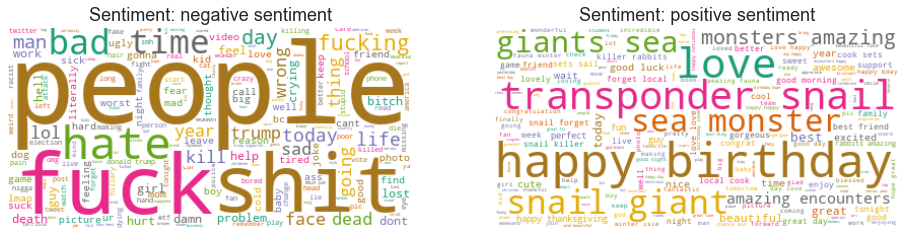

In [173]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(1, 2)

for label in [0, 1]:
    text_list = sa_df[sa_df['label'] == label]['text_wo_ht'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[label]
    ax.imshow(wc, interpolation='bilinear')
    if label == 0:
        ax.set_title('Sentiment: negative sentiment')
    else:
        ax.set_title('Sentiment: positive sentiment')
    ax.axis('off')

plt.show()

### Observations:

#### positive sentiment:

Looking at a few examples, It is observed that all tweets with #TreCru has same tweet content. 
It seems that these tweets are generated by Bots (may be for marketing purpose). 
Following words are from same tweet generated by bot. 

today          14672
snail          14229
transponder    14206
trecru         14190
fun            11687
time           11311
sea            10543
giants         10087
monsters       10066
encounters     10021

Other than above words, most used words to convey positive sentiment include birthday, love, amazing, best, etc.

#### negative sentiment:

Interestingly, people is the most used word associated with negative sentiment, followed by fuck, hate, shit, time,trump, etc.

# Visualize top hash tags in generic tweet by sentiment

In [174]:
# covert hash tag list to single string per tweet
sa_df['ht_string'] = [', '.join(l) for l in sa_df['hashTags']]

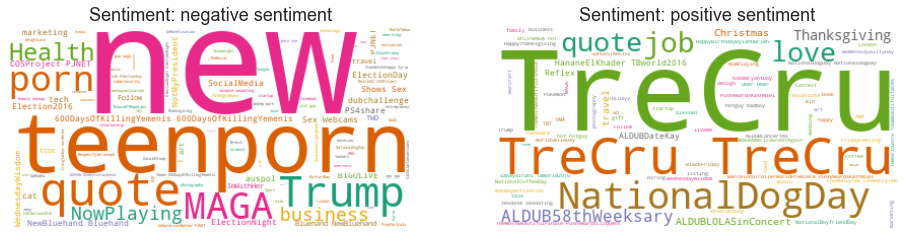

In [175]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(1, 2)

for label in [0, 1]:
    text_list = sa_df[sa_df['label'] == label]['ht_string'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[label]
    ax.imshow(wc, interpolation='bilinear')
    if label == 0:
        ax.set_title('Sentiment: negative sentiment')
    else:
        ax.set_title('Sentiment: positive sentiment')
    ax.axis('off')

plt.show()

## Observations:

'#TreCru' is an example of how easy it is to targate and manipulate the minds of people by creating hype through automated bots.

other than bot created hash tag #TreCru, #NationalDogDay, #quote, #love, #Thanksgiving, etc were most prominent words used in tweets with positive sentiment.


# Visualize the most used words in US Election tweets (excluding hash tags) by sentiment 

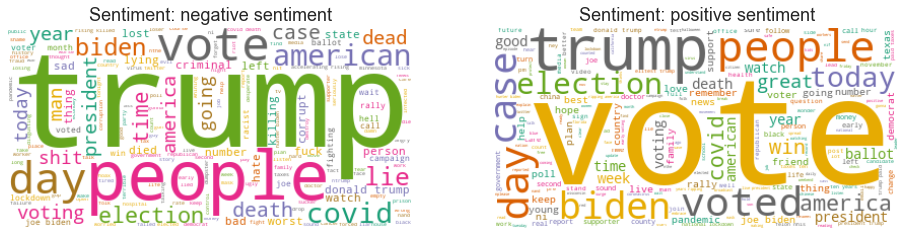

In [176]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(1, 2)

for label in [0, 1]:
    text_list = US_Elections_2020[US_Elections_2020['sentiment'] == label]['text_wo_ht'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[label]
    ax.imshow(wc, interpolation='bilinear')
    if label == 0:
        ax.set_title('Sentiment: negative sentiment')
    else:
        ax.set_title('Sentiment: positive sentiment')
    ax.axis('off')

plt.show()

### Observations:

#COVID is the most used hash tag associated with negative sentiment as visualized below. The death can be associated with #COVID. The word People is present in both negative and positive sentiment; and hence, it can be considered sentiment neutral word. The presence of word american with negative sentiment conveys the sentiment of people of US about election and situation around #COVID.
Trump is most used word and hash tag in all the tweets. 

# Visualize the top hash tags in US Election tweets by sentiment

In [177]:
# covert hash tag list to single string per tweet
US_Elections_2020['ht_string'] = [', '.join(l) for l in US_Elections_2020['hashTags']]

In [178]:
cv_US_Election_ht = CountVectorizer()
# document-term matrix
US_Election_ht_mat = cv_US_Election_ht.fit_transform(US_Elections_2020.ht_string)
print('Number of words with document frequncy > 0.1%: ', len(cv_US_Election_ht.get_feature_names()))

Number of words with document frequncy > 0.1%:  1075


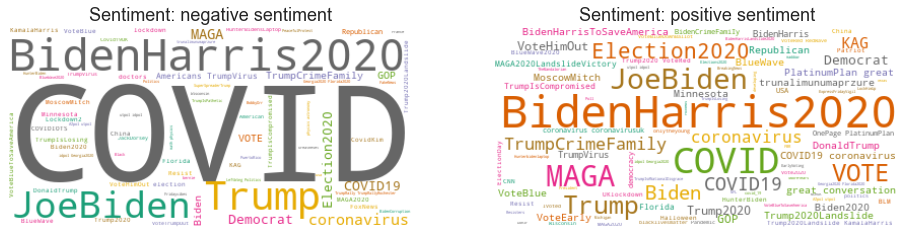

In [179]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(1, 2)

for label in [0, 1]:
    text_list = US_Elections_2020[US_Elections_2020['sentiment'] == label]['ht_string'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[label]
    ax.imshow(wc, interpolation='bilinear')
    if label == 0:
        ax.set_title('Sentiment: negative sentiment')
    else:
        ax.set_title('Sentiment: positive sentiment')
    ax.axis('off')

plt.show()

### Observations:
#COVID is the most used hash tag associated with negative sentiment. It is interesting to note that second most used hash tag in the same category is #BidenHarris2020. This could be a part of democratic strategy to capitalize on the failure of Trump administration's effort to contain COVID. 

At the same time, #BiddenHarris2020 is also the most used hash tag associated with positive sentiment. It seems that the part of the democratic strategy is to highlight the failure of opposition and share positive message about future prospects under Biden administration.

On republican side, there is a lack of clear strategy around campagin on twitter.

# Determine a political party

We will use two prong approach:
1) calssify tweets using known campaign hash tags.
2) complement it with ML model

## 1) Use hash tags to prepare dataset for model training
First, We will use top 30 hash tags to classify the tweets into Democrats and Republican. We exclude hash tag that doesn't suggest any polarity. (ex: trump,minnesota, american, etc.)
We assumed that people speaking about COVID are democrates mostly.

In [180]:
# create dataframe from matrix
US_Election_ht_dtm = pd.DataFrame(US_Election_ht_mat.toarray(), columns = cv_US_Election_ht.get_feature_names())
US_Election_ht_dtm.sum().sort_values(ascending = False)[0:30]

bidenharris2020       312
covid                 270
joebiden              160
trump                 154
maga                  124
coronavirus            84
vote                   80
election2020           75
covid19                73
biden                  61
trumpcrimefamily       58
gop                    38
kag                    35
trump2020              33
democrats              29
votehimout             28
trumpvirus             27
voteblue               23
republican             22
moscowmitch            22
minnesota              20
trump2020landslide     20
democrat               20
biden2020              18
trumpiscompromised     18
bluewave               17
americans              16
resist                 15
donaldtrump            15
maga2020               15
dtype: int64

In [181]:
REP_ht = ['maga2020', 'trump2020landslide','trump2020', 'kag','gop', 'maga']
DEM_ht = ['bidenharris2020', 'covid', 'joebiden', 'coronavirus', 'covid19', 'trumpcrimefamily','votehimout', 'trumpvirus', 
          'voteblue', 'moscowmitch','biden2020', 'trumpiscompromised', 'bluewave', 'resist' ]

In [182]:
def decide_party(text):
    for word in text.split():
        if word in REP_ht:
            return 'republican'
        elif word in DEM_ht:
            return 'democrat'
    return None
        
US_Elections_2020['party'] = US_Elections_2020.text.apply(decide_party)

In [183]:
print('identified tweets:', US_Elections_2020['party'].count())

identified tweets: 975


### This method identifies 975 tweets as either democrat or republican. we will complement this with ml model.
#### We will use labelled tweet by hash tags to build a model that learn to classify tweet into democrat and republican. Given the small size of data, we can not quantify the model accuracy. But the method would work well with large dataset.

## 2) Build model to identify political party of a tweet

In [184]:
party_df = US_Elections_2020[['text', 'party']]
party_df_train = party_df[~party_df['party'].isnull()]

In [185]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(party_df_train['text'], party_df_train['party'],
                                                    test_size=.20, random_state=seed,
                                                    stratify= party_df_train['party'],
                                                    shuffle = True)

# replace null values with emppty string
X_train = X_train.replace(np.nan, '', regex=True)
X_test = X_test.replace(np.nan, '', regex=True)

# Check dimensions
print(f"Train: {X_train.shape[0]} rows")
print(f"Test: {X_test.shape[0]} rows")

Train: 780 rows
Test: 195 rows


#### we will train SGD Classifier and tune it as follows using only grid search

In [186]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [5, 10, 15],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'model__fit_intercept': [True, False],
              'model__alpha': np.linspace(0.00006, 0.0004, 5)}

g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)

# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [187]:
g_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__fit_intercept,param_vectoriser__min_df,param_vectoriser__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.035905,0.006525,0.007181,3.995421e-04,0.000145,False,10,"(1, 2)","{'model__alpha': 0.000145, 'model__fit_intercept': False, 'vectoriser__min_df': 10, 'vectoriser_...",0.987179,0.99359,1.0,0.993590,1.0,0.994872,0.004797,1
20,0.026529,0.012719,0.005585,4.877029e-04,0.000145,False,10,"(1, 1)","{'model__alpha': 0.000145, 'model__fit_intercept': False, 'vectoriser__min_df': 10, 'vectoriser_...",0.987179,0.99359,1.0,0.993590,1.0,0.994872,0.004797,1
14,0.019947,0.000631,0.005385,4.886367e-04,0.000145,True,10,"(1, 1)","{'model__alpha': 0.000145, 'model__fit_intercept': True, 'vectoriser__min_df': 10, 'vectoriser__...",0.987179,0.99359,1.0,0.993590,1.0,0.994872,0.004797,1
28,0.020345,0.001955,0.004987,4.101908e-07,0.00023,True,15,"(1, 1)","{'model__alpha': 0.00023, 'model__fit_intercept': True, 'vectoriser__min_df': 15, 'vectoriser__n...",0.980769,0.99359,1.0,0.993590,1.0,0.993590,0.007022,4
33,0.038297,0.008311,0.006783,3.989705e-04,0.00023,False,10,"(1, 2)","{'model__alpha': 0.00023, 'model__fit_intercept': False, 'vectoriser__min_df': 10, 'vectoriser__...",0.987179,0.99359,1.0,0.987179,1.0,0.993590,0.005734,4


In [188]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

,alpha,fit_intercept,min_df,ngram_range,split0,split1,split2,split3,split4,mean
21,0.000145,False,10,"(1, 2)",0.987179,0.99359,1.0,0.993590,1.0,0.994872
20,0.000145,False,10,"(1, 1)",0.987179,0.99359,1.0,0.993590,1.0,0.994872
14,0.000145,True,10,"(1, 1)",0.987179,0.99359,1.0,0.993590,1.0,0.994872
28,0.00023,True,15,"(1, 1)",0.980769,0.99359,1.0,0.993590,1.0,0.993590
33,0.00023,False,10,"(1, 2)",0.987179,0.99359,1.0,0.987179,1.0,0.993590


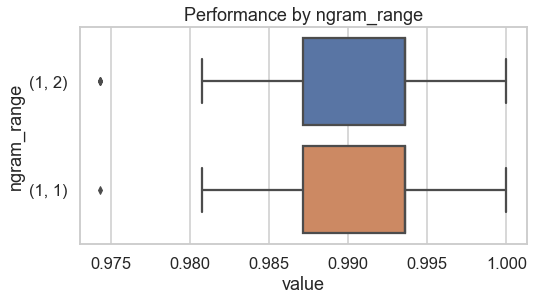

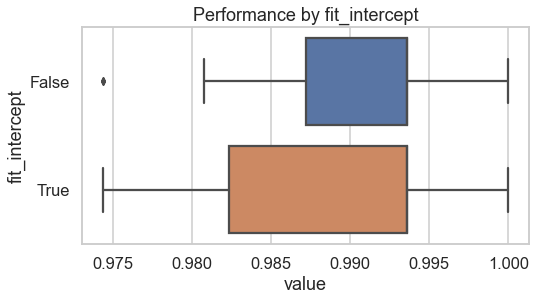

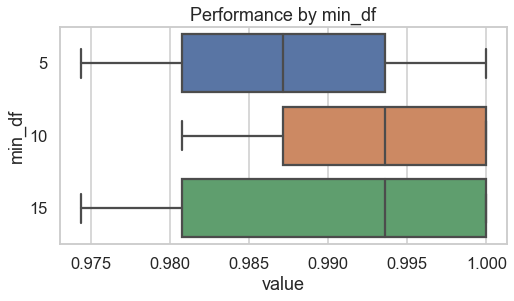

In [189]:
# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['min_df', 
                                  'ngram_range',  
                                  'fit_intercept'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)
# Plot performance
for param in ['ngram_range', 'fit_intercept', 'min_df']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    #plt.xlim(.90, );

In total, we have tested 60 models with various combinations of parameters mentioned in the parameter map above.
Based on the results of tunning, we will choose min_df = 10, ngram_range = (1,2) (unigrams and bigrams), fit_intercept = True (default), and alpha = 0.000145.

### Bonus: 
Bigrams are tested during training and will be used as features in the final model for party classification. ngram_range = (1,2) means that model will use combination of bigrams and unigrams. 

# Best model for party identification

SGD with min_df = 10, ngram_range = (1,2) (unigrams and bigrams), fit_intercept = True (default), and alpha = 0.000145.

In [190]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(min_df=10, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge', alpha = 0.000145))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.6, min_df=10, ngram_range=(1, 2))),
                ('model', SGDClassifier(alpha=0.000145, random_state=123))])

In [191]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

,coef
joebiden,-5.121821
trumpcrimefamily,-4.080200
bluewave,-3.724274
covid,-3.547804
man,-1.794159
...,...
president,0.843059
maga kag,2.380029
kag,2.888591
gop,3.780290


## interpretation of model coefficients
By looking at the value of coefficients, we can say that the model assigns negative value to the word asscoiated with democratic party and positive value to the word with republic party. The magnitute indicates the extremity of tweet affiliation to either party.

# Model Performance 

### model performance on train set

In [192]:
# model performance on train set
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=['democrat', 'republican']))

              precision    recall  f1-score   support

    democrat       1.00      1.00      1.00       632
  republican       1.00      1.00      1.00       148

    accuracy                           1.00       780
   macro avg       1.00      1.00      1.00       780
weighted avg       1.00      1.00      1.00       780



### model performance on test set

In [193]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test,
                            target_names=['democrat', 'republican']))

              precision    recall  f1-score   support

    democrat       1.00      0.99      1.00       159
  republican       0.97      1.00      0.99        36

    accuracy                           0.99       195
   macro avg       0.99      1.00      0.99       195
weighted avg       1.00      0.99      0.99       195



### visualize the results

In [194]:
# Create function for easy reuse
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=',', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

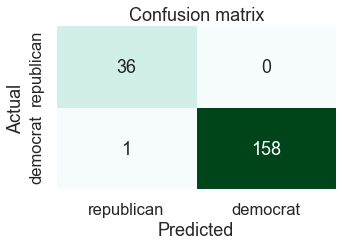

In [195]:
plot_cm(test_pred, y_test, target_names=['democrat', 'republican'])

By looking at the acuracy, precision, recall and f-score of the model on both train and test set, we can say that the model performs well. All the scores are similar for both train and test set, which indicates the correct tuning of model. 

### Identify party affiliation for remaining tweets using the model

In [196]:
party_df.loc[party_df['party'].isnull(), 'party'] = pipe.predict(party_df_test['text'])

# Distribution of the political affiliations of the tweets

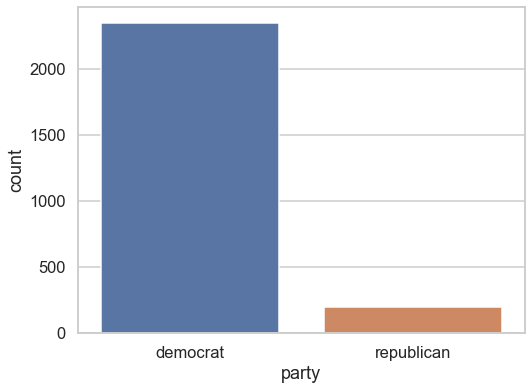

In [197]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot()
ax = sns.countplot(x="party", data=party_df)

#### Majority of tweets are affiliated with democrats.

# Visulize the words used by democrats and republican

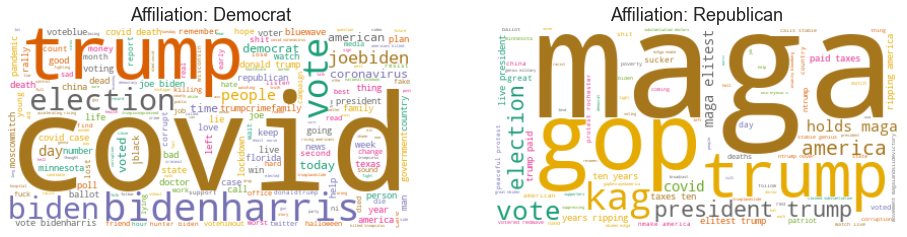

In [198]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(1, 2)

for i, label in enumerate(['democrat', 'republican']):
    text_list = party_df[party_df['party'] == label]['text'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[i]
    ax.imshow(wc, interpolation='bilinear')
    if label == 'democrat':
        ax.set_title('Affiliation: Democrat')
    else:
        ax.set_title('Affiliation: Republican')
    ax.axis('off')

plt.show()

### Observation:
Both Democrats and Republication refers to trump in their tweets.
Democrats talk more about Joe Biden and Kamla Harris.
COVID is the most used word by democrates in their tweets. Republican don't talk much about COVID in their tweets.

# Build a model to classify tweets based on sentiment

In [199]:
sa_df = sa_df.drop(['ID', 'hashTags', 'userNames', 'text_wo_ht', 'ht_string'], axis = 1)
sa_df.head()

,text,label
0,josh jenkins forward tab breeders crown super sunday,1
1,congratulations pakistan notestteam odds ji pakzindabadrallies,1
2,september maine mendozas surprise thanksgiving party threw fans,1
3,newly painted walls custodial painters summer great job ladies ec,1
4,excited july feschotte lab relocating mbg,1


### We have imbalanced dataset. The number pf positive sentiments is twice the number of negative sentiments. The imbalanced is taken care off by doing stratified split before training.

[Text(0, 0.5, 'count')]

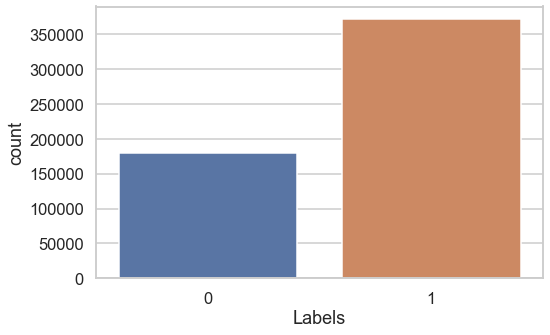

In [200]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=sa_df.label.unique(), y=sa_df.label.value_counts());
ax.set(xlabel = 'Labels')
ax.set(ylabel = 'count')

### Split the data in proportion of 70/30 (train/test) before doing any model preparation/development to avoid leakage of information from test set. 

In [201]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(sa_df['text'], sa_df['label'], test_size=.30, random_state=seed,stratify=sa_df['label'], shuffle = True)

# replace null values with emppty string
X_train = X_train.replace(np.nan, '', regex=True)
X_test = X_test.replace(np.nan, '', regex=True)

# add label back
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check dimensions
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['label'].value_counts()}\n")
print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['label'].value_counts())

Train: 385273 rows and 2 columns
1    259938
0    125335
Name: label, dtype: int64

Test: 165118 rows and 2 columns
1    111403
0     53715
Name: label, dtype: int64


# Rule based classification using VADER (Valence Aware Dictionary and sEntiment Reasoner)
Before building ML model, we will use rule based technique to classify tweets. The performance of ML model will be compared with rule based technique. 

Rule based classifier works by assigning score to each word in vocabulary. Given a sentence, analyzer calculates the aggregate score from the words present in the sentence, which is used to classify the text.

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License].

Reference: https://github.com/cjhutto/vaderSentiment

In [202]:
# analyser
sia = SentimentIntensityAnalyzer()
# create scores columns
train[['negative', 'neutral', 'positive', 'compound']] = train.text.apply(lambda x: sia.polarity_scores(str(x))).apply(pd.Series)
train.head()

,text,label,negative,neutral,positive,compound
366491,dates numbers eyes haha,0,0.000,0.500,0.500,0.4588
332209,devereaux dilemma virus threatens earth scifi,0,0.518,0.482,0.000,-0.5106
425084,naughty looked nice,1,0.000,0.417,0.583,0.4215
519699,bixbeat mixtape great artiste join movement,1,0.000,0.388,0.612,0.7430
64655,blessings volunteers lending helping hand victims earthquake italy great work,1,0.113,0.246,0.640,0.8934


Analyzer returns score for negative, neutral, positive, and compunded score for each tweet.

## visulize the rule-based score
check if the sentiment of tweets are linearly seperable just using the calculated scores.

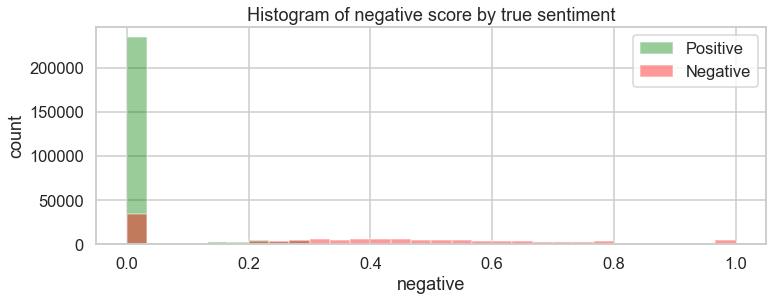

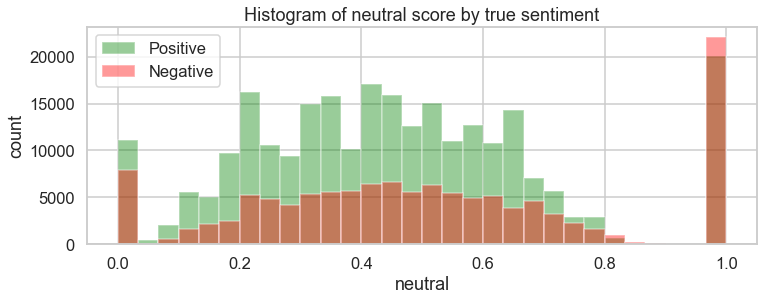

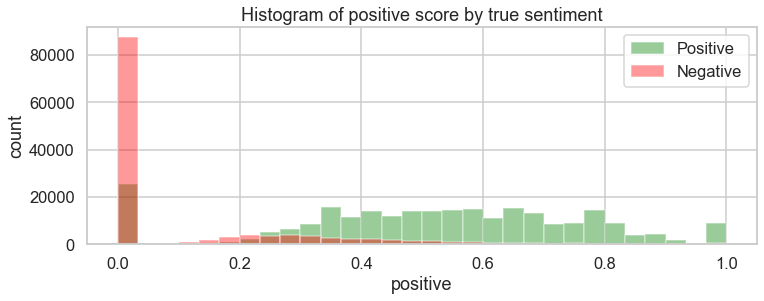

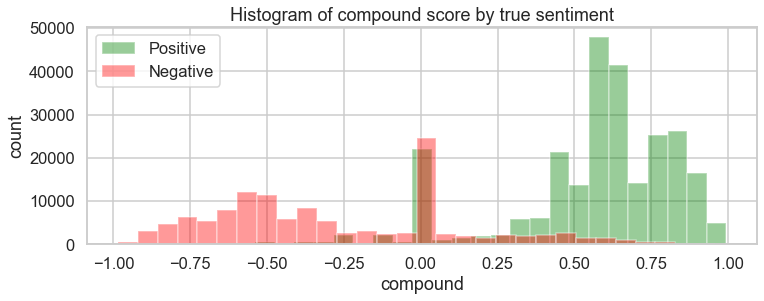

In [204]:
for var in ['negative', 'neutral', 'positive', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train[train.label ==1][var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(train.query("label==0")[var], bins=30, kde=False, 
                 color='red', label='Negative')
    plt.legend()
    plt.ylabel('count')
    plt.title(f'Histogram of {var} score by true sentiment');

### It can be seen from the graphs that about 80% of the tweets can be calssified using positive or compounded scores.

In [205]:
# decide polarity based on positive and negative score.
# if positive score is greater than negative score, predict the sentiment as positive, otherwise negative.
train['vader_polarity'] = np.where(train['positive']>train['negative'], 1, 0)
label_names=['negative', 'positive']
print(classification_report(train['label'], 
                            train['vader_polarity'], 
                            target_names=label_names))

              precision    recall  f1-score   support

    negative       0.78      0.84      0.81    125335
    positive       0.92      0.89      0.90    259938

    accuracy                           0.87    385273
   macro avg       0.85      0.86      0.85    385273
weighted avg       0.87      0.87      0.87    385273



### Visulize the result of rule-based calssifier using confusion matrix

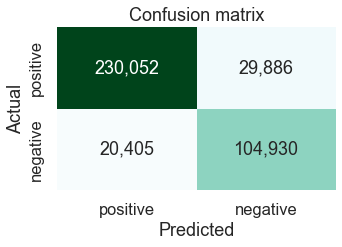

In [206]:
# Plot confusion matrix
plot_cm(train['label'], train['vader_polarity'])

              precision    recall  f1-score   support

    negative       0.78      0.84      0.81    125335
    positive       0.92      0.89      0.90    259938

    accuracy                           0.87    385273
   macro avg       0.85      0.86      0.85    385273
weighted avg       0.87      0.87      0.87    385273



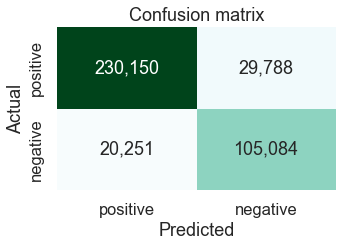

In [207]:
# use compound score to classify tweets
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['label'], 
                            train['vader_compound'], 
                            target_names=label_names))
plot_cm(train['label'], train['vader_compound'])

### It can be seen that use of compound score yields slightly better results compare to use of positive score to classify tweet sentiment.

# Model Preparation, Implementation and Tuning for Sentiment Analysis 

In [208]:
# helper function to create list of models
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('logRegr', LogisticRegression(random_state=seed, max_iter=1000)))
    # knn and SVM takes forever to train, and hence skipped
    # models.append(('knn', KNeighborsClassifier(n_neighbors=5)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('CNB', ComplementNB()))
    # specify parameters via map
    param = {'objective': 'binary:logistic','tree_method':'gpu_hist','random_state':seed, 'max_depth':12, 'max_delta_step': 5, 'scale_pos_weight':0.48217, 'reg_lambda':0, 'n_estimators':50, 'verbosity':2 }  
    models.append(('xgb', XGBClassifier(**param)))
    return models

def assess(X, y, models, cv=5, scoring=['roc_auc', 'accuracy', 'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

#### KNN and SVM takes forever to train, and hence skipped

In [209]:
models = create_baseline_models()

In [210]:
# Preprocess the data
tfidf_vectoriser = TfidfVectorizer(min_df=100, 
                             max_df=.99)
X_train_tfidf = tfidf_vectoriser.fit_transform(X_train)
len(tfidf_vectoriser.get_feature_names())

2977

In [211]:
# Preprocess the data
bow_vectoriser = CountVectorizer(min_df=100, 
                             max_df=.99)
X_train_bow = bow_vectoriser.fit_transform(X_train)
len(bow_vectoriser.get_feature_names())

2977

In [212]:
# Initialise a scaler
scaler = MaxAbsScaler()

In [213]:
# Assess the models
results_bow = assess(scaler.fit_transform(X_train_bow), y_train, models)

results_tfidf = assess(scaler.fit_transform(X_train_tfidf), y_train, models)

In [214]:
print('Model performance\n')
print('Features: bag of words \n',results_bow,'\n\n', 'Features:TF-IDF\n', results_tfidf)

Model performance

Features: bag of words 
                      logRegr       sgd       CNB         xgb
fit_time_mean       5.825335  0.571664  0.099130  113.514741
fit_time_std        1.148617  0.061075  0.015369    3.070796
score_time_mean     0.070027  0.071808  0.096147    0.706607
score_time_std      0.003632  0.003139  0.009200    0.035669
test_accuracy_mean  0.936518  0.928041  0.893660    0.879340
test_accuracy_std   0.001080  0.000621  0.001660    0.001163
test_f1_mean        0.952580  0.945607  0.918293    0.903333
test_f1_std         0.000827  0.000474  0.001383    0.001025
test_roc_auc_mean   0.983520  0.980295  0.956676    0.960200
test_roc_auc_std    0.000195  0.000192  0.000647    0.000811 

 Features:TF-IDF
                      logRegr       sgd       CNB        xgb
fit_time_mean       4.783403  0.583041  0.094545  65.760938
fit_time_std        1.581833  0.018014  0.002579   4.925457
score_time_mean     0.074601  0.077993  0.090559   0.657343
score_time_std      0.003

#### There is no clear winner between TF-IDF and Bag of Words. We will move forward with TF-IDF.

#### Also, in both the cases, logistic regresssion did just slightly better compared to other models. However, SGD has similar performance and run 10 times faster than logistic regression, as shown above. So, we will select SGD as our choice of algorithm and tune it.

## Feature Engineering

We will explore the use of rule based scores as features

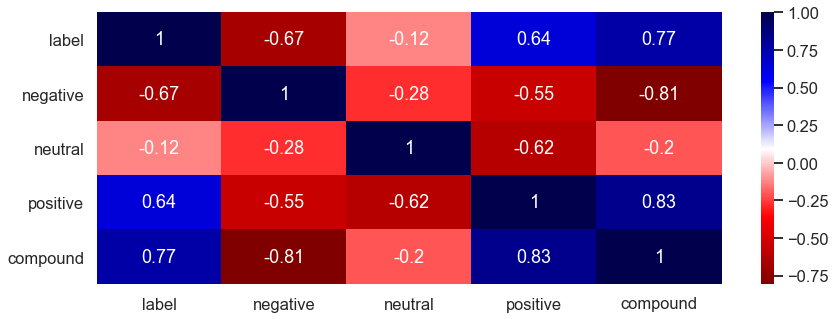

In [215]:
plt.figure(figsize = (14,5))
columns = ['label', 'negative', 'neutral', 'positive', 'compound']
sns.heatmap(train[columns].corr(), annot=True, cmap='seismic_r');

 the compound score has highest correlation with the label

### We will train the logistic regression model with above rule based scores as only features.

In [216]:
# Initialise a model
logRegr =  LogisticRegression(random_state=seed, max_iter=1000)

# Initialise a scaler
scaler_minmax = MinMaxScaler()

# Assess the model using scores
scores = train[['negative', 'neutral', 'positive', 'compound']]
assess(scaler_minmax.fit_transform(scores), y_train, [('logRegr', logRegr)])

,logRegr
fit_time_mean,0.975017
fit_time_std,0.124548
score_time_mean,0.072207
score_time_std,0.002503
test_accuracy_mean,0.872880
test_accuracy_std,0.001432
test_f1_mean,0.903797
test_f1_std,0.001100
test_roc_auc_mean,0.944056
test_roc_auc_std,0.000840


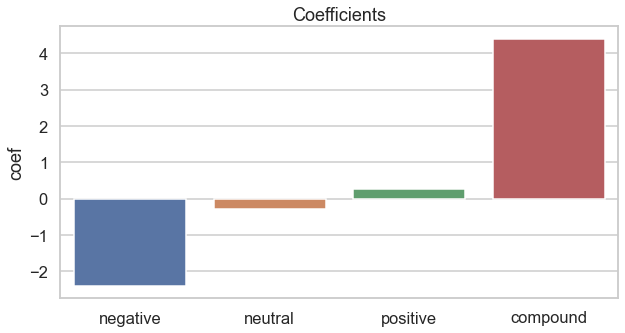

In [217]:
# Fit to training data
logRegr.fit(scores, y_train)

# Get coefficients
coefs = pd.DataFrame(data=logRegr.coef_, columns=scores.columns).T

coefs.rename(columns={0: 'coef'}, inplace=True)
# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefs.index, y='coef', data=coefs)
plt.title('Coefficients');

negative and compound has highest magnitude for coefficients. We will train model including them as additional features to see if these features lead to significant imrpovement.

In [218]:
# Add features to sparse matrix
selected_scores = train[['negative', 'compound']]

X_train_extended = hstack([X_train_tfidf, csr_matrix(scaler.fit_transform(selected_scores))])

# Assess
assess(X_train_extended, y_train, [('logRegr', logRegr)])

,logRegr
fit_time_mean,7.373674
fit_time_std,0.776826
score_time_mean,0.071275
score_time_std,0.013071
test_accuracy_mean,0.941667
test_accuracy_std,0.001128
test_f1_mean,0.956691
test_f1_std,0.000837
test_roc_auc_mean,0.985556
test_roc_auc_std,0.000255


The improvement in mean accuracy is not significant. Hence, we will not consider rule based scores as features in our ml models

# Hyper Parameter tunning and cross-validation of selected model (SGD Classifier)

### First, we will do random search to narrow down the search space.

In [219]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer()), ('model', SGDClassifier(random_state=seed))])

# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['hinge', 'log'],
                       'model__alpha': np.linspace(0.00001, 0.001, 10)}

r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)

r_search.fit(X_train, y_train)

# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [220]:
r_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectoriser__min_df,param_vectoriser__max_df,param_model__loss,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,7.361625,0.139129,1.501288,0.104850,100,0.220513,hinge,0.00012,"{'vectoriser__min_df': 100, 'vectoriser__max_df': 0.22051282051282053, 'model__loss': 'hinge', '...",0.930310,0.929881,0.926974,0.930464,0.930036,0.929533,0.001296,1
2,7.247071,0.120927,1.466040,0.102441,100,0.589744,hinge,0.00023,"{'vectoriser__min_df': 100, 'vectoriser__max_df': 0.5897435897435898, 'model__loss': 'hinge', 'm...",0.927870,0.928545,0.925352,0.928686,0.928323,0.927755,0.001233,2
24,7.715178,0.150766,1.435951,0.139812,160,0.753846,log,1e-05,"{'vectoriser__min_df': 160, 'vectoriser__max_df': 0.7538461538461538, 'model__loss': 'log', 'mod...",0.924677,0.924885,0.922147,0.924469,0.923885,0.924012,0.000991,3
15,6.770445,0.041229,1.396865,0.031762,270,0.589744,hinge,0.00023,"{'vectoriser__min_df': 270, 'vectoriser__max_df': 0.5897435897435898, 'model__loss': 'hinge', 'm...",0.906807,0.908546,0.905275,0.907467,0.907442,0.907107,0.001073,4
11,7.163105,0.056399,1.471377,0.061353,10,0.897436,log,0.00023,"{'vectoriser__min_df': 10, 'vectoriser__max_df': 0.8974358974358974, 'model__loss': 'log', 'mode...",0.904717,0.904263,0.902719,0.904625,0.903315,0.903928,0.000782,5


In [221]:
columns = [col for col in r_search_results.columns if re.search(r"split|param_|mean_test_|std_test_", col)]

r_summary = r_search_results[columns].copy()

r_summary.columns = [re.sub(r'_test_score|param_', '', col) for col in r_summary.columns if col not in {'mean_test_score', 'std_test_score'}] + ['mean_test_score', 'std_test_score']

columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]

r_summary.columns = columns
r_summary.head()

,min_df,max_df,loss,alpha,split0,split1,split2,split3,split4,mean_test_score,std_test_score
28,100,0.220513,hinge,0.00012,0.930310,0.929881,0.926974,0.930464,0.930036,0.929533,0.001296
2,100,0.589744,hinge,0.00023,0.927870,0.928545,0.925352,0.928686,0.928323,0.927755,0.001233
24,160,0.753846,log,1e-05,0.924677,0.924885,0.922147,0.924469,0.923885,0.924012,0.000991
15,270,0.589744,hinge,0.00023,0.906807,0.908546,0.905275,0.907467,0.907442,0.907107,0.001073
11,10,0.897436,log,0.00023,0.904717,0.904263,0.902719,0.904625,0.903315,0.903928,0.000782


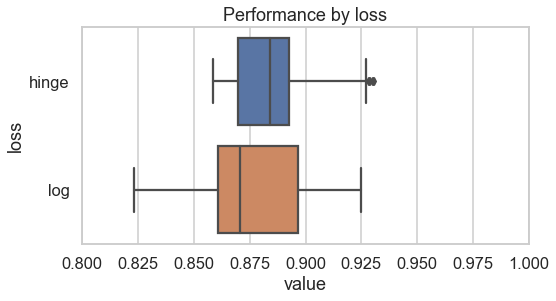

In [222]:
# Create a long dataframe
r_summary_long = pd.melt(r_summary, 
                         id_vars=['min_df', 
                                  'max_df', 
                                  'loss',
                                  'alpha'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
# Plot hyperparameter 'loss'
plt.figure(figsize=(8,4))
plt.title('Performance by loss')
sns.boxplot(x='value', y='loss', data=r_summary_long, 
            orient='h')
plt.xlim(.8, 1.0);

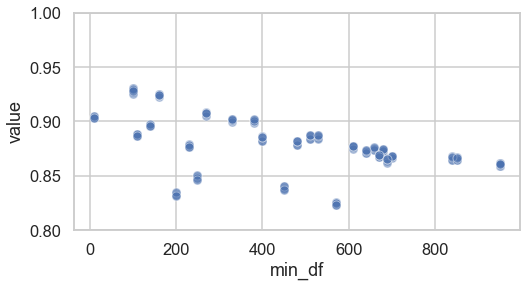

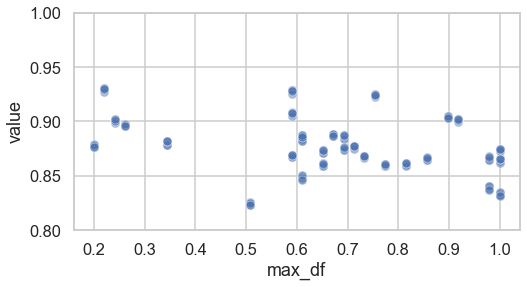

In [223]:
for param in ['min_df', 'max_df']:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=param, y="value", data=r_summary_long, 
                    x_jitter=True, alpha=0.5)
    plt.ylim(.8, 1.0);

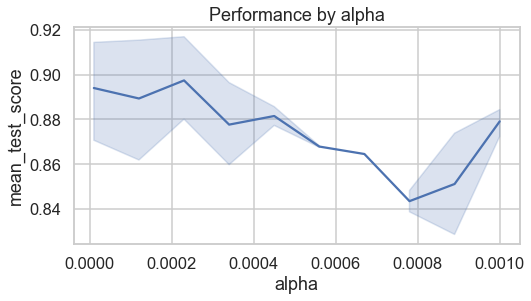

In [224]:
# Plot hyperparameter 'alpha'
plt.figure(figsize=(8,4))
plt.title('Performance by alpha')
sns.lineplot(x='alpha', y='mean_test_score', data=r_summary)

### Next we will do grid search to further fine tune the model

In [225]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])
# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 60, 90],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'model__fit_intercept': [True, False],
              'model__alpha': np.linspace(0.00006, 0.0004, 10)}

g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)
# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [226]:
g_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__fit_intercept,param_vectoriser__min_df,param_vectoriser__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,13.473108,0.282499,2.486524,0.116386,6e-05,False,30,"(1, 2)","{'model__alpha': 6e-05, 'model__fit_intercept': False, 'vectoriser__min_df': 30, 'vectoriser__ng...",0.943456,0.943261,0.941224,0.943287,0.943274,0.942900,0.000841,1
1,13.504721,0.464904,2.396508,0.128357,6e-05,True,30,"(1, 2)","{'model__alpha': 6e-05, 'model__fit_intercept': True, 'vectoriser__min_df': 30, 'vectoriser__ngr...",0.942963,0.942898,0.941146,0.942404,0.943300,0.942542,0.000754,2
6,8.023309,0.269560,1.622416,0.152052,6e-05,False,30,"(1, 1)","{'model__alpha': 6e-05, 'model__fit_intercept': False, 'vectoriser__min_df': 30, 'vectoriser__ng...",0.943002,0.942976,0.940990,0.942871,0.942703,0.942508,0.000766,3
0,7.174840,0.162204,1.498499,0.069916,6e-05,True,30,"(1, 1)","{'model__alpha': 6e-05, 'model__fit_intercept': True, 'vectoriser__min_df': 30, 'vectoriser__ngr...",0.942612,0.942223,0.940562,0.941846,0.942923,0.942033,0.000820,4
19,14.538568,0.716828,2.377294,0.109829,9.77778e-05,False,30,"(1, 2)","{'model__alpha': 9.777777777777778e-05, 'model__fit_intercept': False, 'vectoriser__min_df': 30,...",0.941561,0.941704,0.939524,0.941729,0.941573,0.941218,0.000850,5


In [227]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

,alpha,fit_intercept,min_df,ngram_range,split0,split1,split2,split3,split4,mean
7,6e-05,False,30,"(1, 2)",0.943456,0.943261,0.941224,0.943287,0.943274,0.942900
1,6e-05,True,30,"(1, 2)",0.942963,0.942898,0.941146,0.942404,0.943300,0.942542
6,6e-05,False,30,"(1, 1)",0.943002,0.942976,0.940990,0.942871,0.942703,0.942508
0,6e-05,True,30,"(1, 1)",0.942612,0.942223,0.940562,0.941846,0.942923,0.942033
19,9.77778e-05,False,30,"(1, 2)",0.941561,0.941704,0.939524,0.941729,0.941573,0.941218


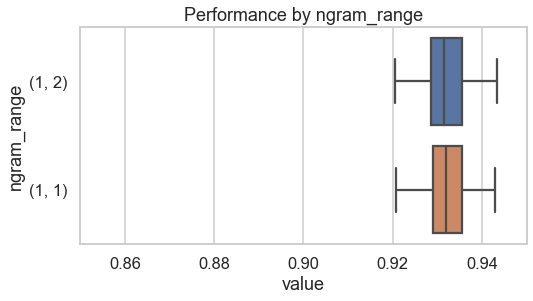

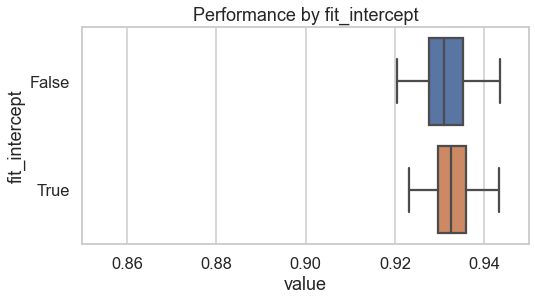

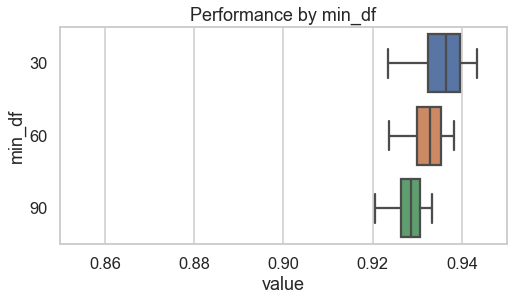

In [228]:
# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['min_df', 
                                  'ngram_range',  
                                  'fit_intercept'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)
# Plot performance
for param in ['ngram_range', 'fit_intercept', 'min_df']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    plt.xlim(.85, .95);

In total, we have tested 120 models with various combinations of parameters mentioned in the parameter map above.
Based on the results of tunning, we will choose min_df = 30, ngram_range = (1,2) (unigrams and bigrams), fit_intercept = True (default), and alpha = 0.00006.

## Bonus: 
Bigrams are tested during training and will be used as features in the final model. ngram_range = (1,2) means that model will use combination of bigrams and unigrams. 

# Best Model

SGD with min_df = 30, ngram_range = (1,2) (unigrams and bigrams), fit_intercept = True (default), and alpha = 0.00006.

In [229]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge', alpha = 0.00006))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.6, min_df=30, ngram_range=(1, 2))),
                ('model', SGDClassifier(alpha=6e-05, random_state=123))])

In [230]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

,coef
bad,-3.482760
hate,-3.440449
sad,-2.930390
fuck,-2.707365
worst,-2.512329
...,...
amazing,6.036549
best,6.311567
great,7.060998
happy,7.383077


## interpretation of model coefficients
By looking at the value of coefficients, we can say that the model assigns negative value to the word with negative sentiment and positive value to the word with positive sentiment. The magnitute indicates the extremity of sentiment associated with word.

# Model Performance 

### model performance on train set

In [231]:
# model performance on train set
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=label_names))

              precision    recall  f1-score   support

    negative       0.93      0.91      0.92    128762
    positive       0.95      0.97      0.96    256511

    accuracy                           0.95    385273
   macro avg       0.94      0.94      0.94    385273
weighted avg       0.95      0.95      0.95    385273



# model performance on test set

In [232]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=label_names))

              precision    recall  f1-score   support

    negative       0.93      0.90      0.91     55447
    positive       0.95      0.97      0.96    109671

    accuracy                           0.94    165118
   macro avg       0.94      0.93      0.94    165118
weighted avg       0.94      0.94      0.94    165118



# Visualize the results

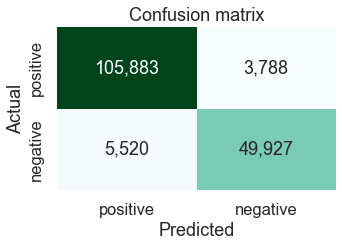

In [233]:
plot_cm(test_pred, y_test, target_names=label_names)

By looking at the acuracy, precision, recall and f-score of the model on both train and test set, we can say that the model performs well. All the scores are similar for both train and test set, which indicates the correct tuning of model. 

# Check the model performance on US elections data set

In [234]:
US_Elections_2020 = pd.read_csv(r'F:\D\Desktop\Projects\MIE1624 Assignment 3\US_Elections_2020_df.csv').drop(['hashTags', 'userNames'], axis = 1)
US_Elections_2020.rename(columns= {'sentiment':'label'}, inplace = True)
US_Elections_2020.text = US_Elections_2020.text.replace(np.nan, '', regex=True)
US_Elections_2020.head()

,text,label,negative_reason
0,afraid nov dec jan bidenharris win frump months damage,0,covid19
1,lord sumption launches recovery initiative promote anotherway deal covid hysteria rushed laws,0,others
2,uber timing biden advisors pressure brazil sanction gov elected,0,covid19
3,seconds american dying trumpvirus donaldtrump thinks success joebiden,1,NaN
4,democrats embrace diversityandinclusion citizens nation vote,1,NaN


In [235]:
test_pred = pipe.predict(US_Elections_2020['text'])
print(classification_report(test_pred, 
                            US_Elections_2020['label'], 
                            target_names=label_names))

              precision    recall  f1-score   support

    negative       0.94      0.58      0.72      2038
    positive       0.34      0.85      0.48       514

    accuracy                           0.63      2552
   macro avg       0.64      0.71      0.60      2552
weighted avg       0.82      0.63      0.67      2552



## Visualize the results

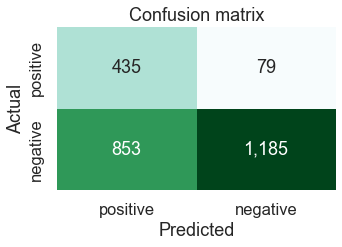

In [236]:
plot_cm(test_pred, US_Elections_2020['label'], target_names=label_names)

### We can see that the model has very high precision for negative class and very high recall for positive class. Overall, the model trained on generaic data, performs decently with overall accuracy of 0.63. The model cannot recall many negative samples and miss classifies the positive samples as negative.

# Build model to classify reason for negative sentiment

In [237]:
US_Elections_2020['negative_reason'].unique()

array(['covid19', 'others', nan, 'discrimination', 'corruption', 'crime'],
      dtype=object)

In [238]:
# count for each reason
US_Elections_2020.groupby(by='negative_reason').count()

,text,label
negative_reason,,
corruption,220,220
covid19,405,405
crime,222,222
discrimination,215,215
others,202,202


### We can see that classes based on reason are not balanced. The negative tweet with 'covid19' as reason are double compare to other reasons.

In [239]:
df = US_Elections_2020[US_Elections_2020['label'] == 0][['text', 'negative_reason']]
df.rename(columns= {'negative_reason':'label'}, inplace = True)
df.head()

,text,label
0,afraid nov dec jan bidenharris win frump months damage,covid19
1,lord sumption launches recovery initiative promote anotherway deal covid hysteria rushed laws,others
2,uber timing biden advisors pressure brazil sanction gov elected,covid19
5,accelerating rising americans killed trumpvirus,discrimination
6,dead americans day times number died benghazi lost,discrimination


In [240]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=.30, random_state=seed,stratify= df['label'], shuffle = True)

# reason to index
reason2idx = {w:i for i,w in enumerate(df['label'].unique())}
# index to reason
idx2reason = {i:w for i,w in enumerate(df['label'].unique())}

y_train.replace(reason2idx, inplace = True)
y_test.replace(reason2idx, inplace = True)

# replace null values with emppty string
X_train = X_train.replace(np.nan, '', regex=True)
X_test = X_test.replace(np.nan, '', regex=True)

# Check dimensions
print(f"Train: {X_train.shape[0]} rows")
print(f"Test: {X_test.shape[0]} rows")

Train: 884 rows
Test: 380 rows


# try three different models and choose best performing model for tuning

In [241]:
# helper function to create list of models
def create_baseline_models_reason():
    """Create list of baseline models."""
    models = []
    models.append(('logRegr', LogisticRegression(random_state=seed, max_iter=1000)))
    models.append(('CNB', MultinomialNB()))
    # specify parameters via map
    param = {'objective': 'multi:softprob','tree_method':'gpu_hist','random_state':seed, 'max_depth':6, 'max_delta_step': 5, 'scale_pos_weight':0.48217, 'reg_lambda':0, 'n_estimators':50, 'verbosity':0 }  
    models.append(('xgb', XGBClassifier(**param)))
    return models

In [242]:
models = create_baseline_models_reason()

In [243]:
# Preprocess the data
tfidf_vectoriser = TfidfVectorizer(max_df = 30, min_df = 5)
X_train_tfidf = tfidf_vectoriser.fit_transform(X_train)

In [244]:
# Preprocess the data
bow_vectoriser = CountVectorizer(max_df = 30, min_df = 5)
X_train_bow = bow_vectoriser.fit_transform(X_train)

In [245]:
assess(X_train_tfidf, y_train, models, scoring = 'accuracy' )

,logRegr,CNB,xgb
fit_time_mean,0.038645,0.000000,4.334123
fit_time_std,0.007995,0.000000,0.257029
score_time_mean,0.000207,0.000000,0.003125
score_time_std,0.000462,0.000000,0.006987
test_score_mean,0.306600,0.316782,0.294087
test_score_std,0.025084,0.031750,0.030606


In [246]:
assess(X_train_bow, y_train, models, scoring = 'accuracy')

,logRegr,CNB,xgb
fit_time_mean,0.046879,0.003125,4.323546
fit_time_std,0.018528,0.006987,0.111844
score_time_mean,0.000598,0.000000,0.004322
score_time_std,0.000891,0.000000,0.006828
test_score_mean,0.298665,0.300924,0.305438
test_score_std,0.017623,0.025371,0.013460


### Based on the accuracy of three models tested for tf-idf and bow, we will tune logistic regression with tf-idf.

# Hyper Parameter tunning and cross-validation of selected model (Logistic Regression)

For this model, we will directly perform the grid-search for tuning. we will check n-gram, min_df, and C (inverse of regularization).

In [247]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer()),
                 ('scaler', MaxAbsScaler()),
                 ('model', LogisticRegression(random_state=seed, multi_class='multinomial'))])
# Prepare a grid search
param_grid = {'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__max_df': [20,30, 40],
              'vectoriser__min_df': [4, 6],
              'model__C': np.linspace(0.05, 0.5, 10)}

g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1, return_train_score=True)
g_search.fit(X_train, y_train)

# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [248]:
g_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_vectoriser__max_df,param_vectoriser__min_df,param_vectoriser__ngram_range,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
48,0.063841,0.007658,0.004320,0.006105,0.25,20,4,"(1, 1)","{'model__C': 0.25, 'vectoriser__max_df': 20, 'vectoriser__min_df': 4, 'vectoriser__ngram_range':...",0.322034,...,0.334855,0.010762,1,0.422914,0.428571,0.424328,0.400283,0.394068,0.414033,0.014028
20,0.056446,0.012136,0.005718,0.005748,0.1,40,4,"(1, 1)","{'model__C': 0.1, 'vectoriser__max_df': 40, 'vectoriser__min_df': 4, 'vectoriser__ngram_range': ...",0.344633,...,0.334842,0.012053,2,0.338048,0.345120,0.345120,0.332390,0.333333,0.338802,0.005503
41,0.126662,0.038405,0.011967,0.004678,0.2,30,4,"(1, 2)","{'model__C': 0.2, 'vectoriser__max_df': 30, 'vectoriser__min_df': 4, 'vectoriser__ngram_range': ...",0.327684,...,0.332589,0.009356,3,0.398868,0.397454,0.381895,0.374823,0.361582,0.382925,0.014054
50,0.070687,0.015740,0.005518,0.005717,0.25,20,6,"(1, 1)","{'model__C': 0.25, 'vectoriser__max_df': 20, 'vectoriser__min_df': 6, 'vectoriser__ngram_range':...",0.344633,...,0.332582,0.011585,4,0.367751,0.369165,0.366337,0.383310,0.344633,0.366239,0.012402
0,0.054851,0.006769,0.008059,0.006262,0.05,20,4,"(1, 1)","{'model__C': 0.05, 'vectoriser__max_df': 20, 'vectoriser__min_df': 4, 'vectoriser__ngram_range':...",0.338983,...,0.332576,0.010826,5,0.330976,0.335219,0.335219,0.328147,0.333333,0.332579,0.002710


In [249]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score', 'mean_train_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

,C,max_df,min_df,ngram_range,split0,split1,split2,split3,split4,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean,mean_train_score
48,0.25,20,4,"(1, 1)",0.322034,0.338983,0.322034,0.344633,0.346591,0.422914,0.428571,0.424328,0.400283,0.394068,0.334855,0.414033
20,0.1,40,4,"(1, 1)",0.344633,0.327684,0.316384,0.350282,0.335227,0.338048,0.345120,0.345120,0.332390,0.333333,0.334842,0.338802
41,0.2,30,4,"(1, 2)",0.327684,0.338983,0.316384,0.338983,0.340909,0.398868,0.397454,0.381895,0.374823,0.361582,0.332589,0.382925
50,0.25,20,6,"(1, 1)",0.344633,0.338983,0.310734,0.333333,0.335227,0.367751,0.369165,0.366337,0.383310,0.344633,0.332582,0.366239
0,0.05,20,4,"(1, 1)",0.338983,0.322034,0.322034,0.350282,0.329545,0.330976,0.335219,0.335219,0.328147,0.333333,0.332576,0.332579


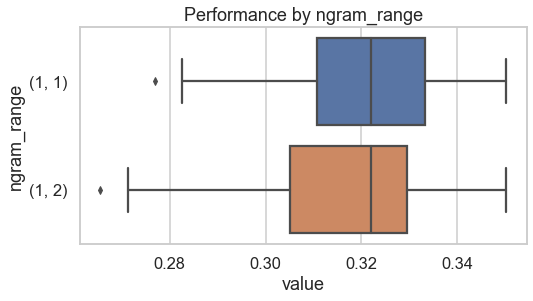

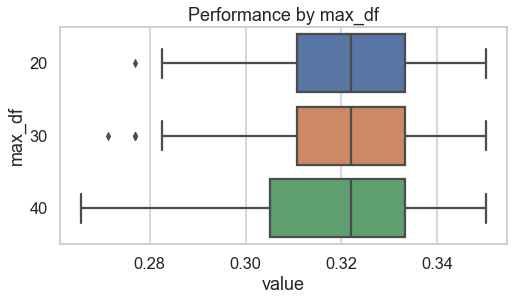

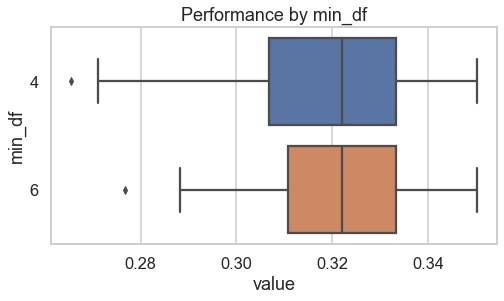

In [250]:
# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['ngram_range', 'max_df', 'min_df'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)

# Plot performance
for param in [ 'ngram_range', 'max_df', 'min_df']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    #plt.xlim(0.22, 0.6);

[Text(0, 0.5, 'mean_accuracy')]

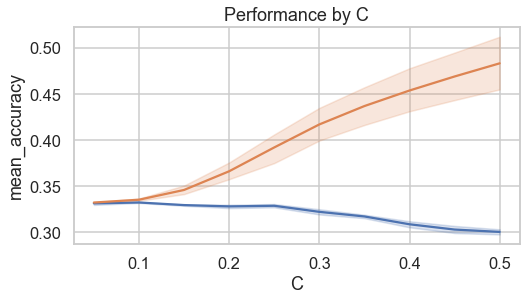

In [251]:
# Plot hyperparameter 'C'
plt.figure(figsize=(8,4))
plt.title('Performance by C')
ax = sns.lineplot(x='C', y='mean', data=g_summary)
ax= sns.lineplot(x='C', y='mean_train_score', data=g_summary)
ax.set(ylabel = 'mean_accuracy')

From the above graph, it is clear that model starts to overfit on train set for C grater than 0.1. In the best case, model give accuracy of 0.33.

In total, we tested 180 models with various combinations of parameters mentioned in the parameter map above.
Based on the results of tunning, we will choose min_df = 4, max_df = 20, ngram_range = (1, 1) (unigrams), fit_intercept = True (default), and C = 0.25

## Bonus: 
Bigrams are tested during training and will be not be used as features in the final model.

# Best Model

In [252]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(min_df=4, max_df = 20, ngram_range=(1,1))),
                 ('model', LogisticRegression(random_state=seed, C=0.25, multi_class='multinomial'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser', TfidfVectorizer(max_df=20, min_df=4)),
                ('model',
                 LogisticRegression(C=0.25, multi_class='multinomial',
                                    random_state=123))])

# Model Performance

In [253]:
# model perforamnce on train set
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, y_train)) 

              precision    recall  f1-score   support

           0       1.00      0.34      0.51       833
           1       0.02      0.60      0.04         5
           2       0.13      0.79      0.22        24
           3       0.08      0.92      0.14        13
           4       0.06      1.00      0.11         9

    accuracy                           0.37       884
   macro avg       0.26      0.73      0.20       884
weighted avg       0.94      0.37      0.49       884



In [254]:
# model perforamnce on test set
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, y_test)) 

              precision    recall  f1-score   support

           0       0.98      0.33      0.49       369
           1       0.02      1.00      0.03         1
           2       0.06      0.80      0.12         5
           3       0.05      0.75      0.09         4
           4       0.01      1.00      0.03         1

    accuracy                           0.34       380
   macro avg       0.22      0.78      0.15       380
weighted avg       0.96      0.34      0.48       380



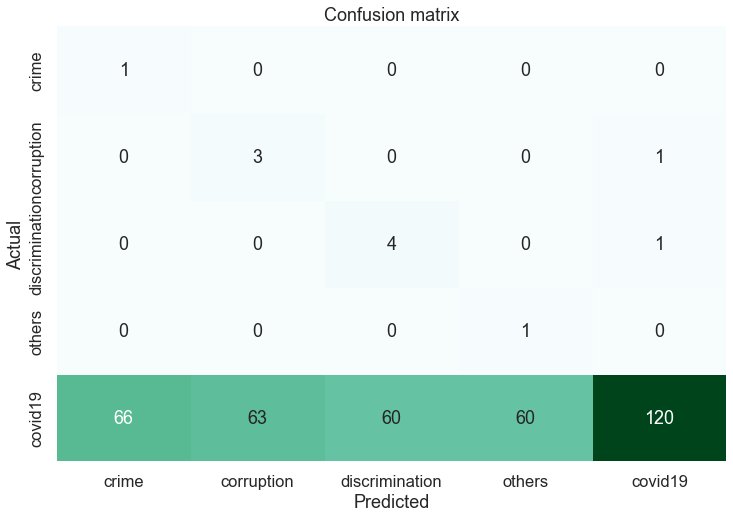

In [255]:
# plot the result
plot_cm(test_pred, y_test, ['covid19', 'others', 'discrimination', 'corruption', 'crime'], figsize =(12,8))

### Let's explore why model is doing bad?

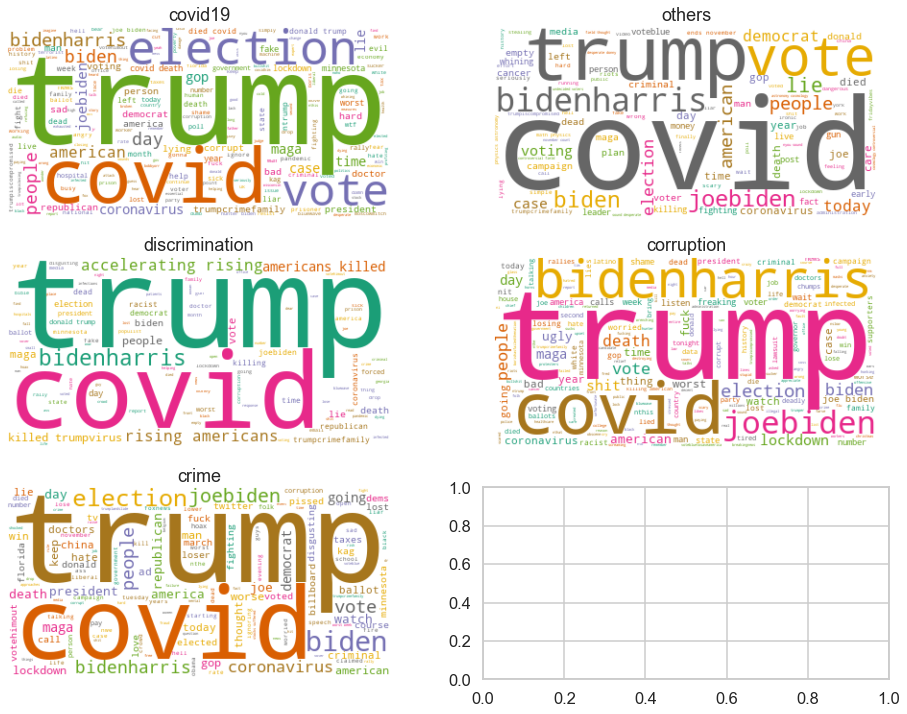

In [256]:
fig = plt.figure(figsize = (16, 12))
axarr = fig.subplots(3,2)

for idx, reason in idx2reason.items():
    text_list = df[df['label'] == reason]['text'].tolist()
    text_blob = ' '.join(text_list)
    wc.generate(text_blob)
    ax = axarr.flat[idx]
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(reason)
    ax.axis('off')

plt.show()

#### Above word clouds explain the reason behind poor performance of the model. The tweet in all the classes are dominated by same words. Hence, it is impossible for model to learn anything useful from features created using these words. In other words, there is too much noise.  

# How to improve accuracy?

### Model to identify reason
#### One way to improve accuracy in such scenarion is to further clean the text by removing common words observed among different classes. (in this example, those words could be 'trump', 'covid', 'biddenharris', etc.)

#### Another way would be to use embeddings in combination with attention or memeory based deep learning models. Embeddings such as word2vec encode the context in which the words is used. Hence, the deep learning model trained using such embeddings would be able to differentiate between the context in which they are used.

### Model to identify sentiment
#### our model to identify sentiments did well on the generic dataset with greater than 90% accuracy. Further, we can train deep learning based model with word embeddings. The LSTM learns the pattern of sequence of words. Word Embeddings create the word representation in the context of surrounding word. Combined together, it will further imporve the accuracy.
#### To improve the accuracy of generic model on domain specific model such as election data, we could include more demain specific words to vocabulary.


# How each party is viewed in eyes of public? What can public opinion on Twitter tell us about the US political landscape in 2020?

- #### In our dataset, it seems that most of the tweets are affiliated with democratic party. So before coming to conclusion, it is imperative that the method of data collection is evaluated. 

- #### Based on the the data that we have, it is ceratin that COVID is one of the most important topic of discussion. It is observed that Republicans don't prefer to talk about COVID on Twitter compared to Democrats.
- #### Among all the personalitites, Donald Trump is most discussed, followed by Joe Bidden. 
- #### It can also be said that the Biden campign is receiving good support on twitter based on the popularity of hash tag #BiddenHarris2020.
- #### In tweets with negative sentiment, use of words Trump and COVID dominates. The negative sentiment of tweet could be directly attributed to Trump administration's failure to contain COVID in US.




# Bonus: deep learning (GRU is trained on generic tweet dataset to classify absed on sentiments)

Due to lack of computation resoures and the amount of time required, the network is not tuned. Hence, the performance of suboptimal network is not as good as the models built above.

In [364]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.autograd import Variable

import random
from collections import Counter, OrderedDict

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [365]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset 

In [366]:
sa_df = sa_df[sa_df['text'] != '']
sa_df.head()

,text,label
0,josh jenkins forward tab breeders crown super sunday,1
1,congratulations pakistan notestteam odds ji pakzindabadrallies,1
2,september maine mendozas surprise thanksgiving party threw fans,1
3,newly painted walls custodial painters summer great job ladies ec,1
4,excited july feschotte lab relocating mbg,1


# Indexer

In [367]:
# indexer
def indexer(phrase):
    return [word2idx[w] for w in phrase.split()]

## Tokenize tweet, convert to index and calculate length

In [368]:
class TextClassificationData(Dataset):

    def __init__(self, df, max_len = None):
        
        #self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df = df
        self.df['text'] = self.df.text.apply(lambda x: x.strip())
        self.df['text_idx'] = self.df.text.apply(indexer)
        self.df['text_len'] = self.df.text_idx.apply(len)

        if max_len != None:
            self.max_len = max_len
            self.df['text_len'] = self.df.text_len.apply(lambda x: self.max_len if x > self.max_len else x)
        else:
             self.max_len = self.df['text_len'].max()

        self.df['text_padded'] = self.df.text_idx.apply(self.pad_data)
        self.df.reset_index(inplace = True)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.text_padded[idx]
        y = self.df.label[idx]
        lens = self.df.text_len[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.max_len,), dtype=np.int64)
        if len(s) > self.max_len:
            padded[:] = s[:self.max_len]
        else: 
            padded[:len(s)] = s
        return padded

# Define model architecture, and forward pass

In [429]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # x -> batch_size, sequence_length, embedding_dim
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first = True)
        
        # First fully connected layer
        self.fc1 = nn.Linear(hidden_size, 256)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(256, num_classes)
        #self.fc = nn.Linear(hidden_size, num_classes)

    
    def forward(self, x, lens):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        #print('h0 shape:', h0.shape)

        embedding = self.embedding(x)
        # embedding -> batch_size, max_seq_len, embedding_dim
        #print('embedding:', embedding.shape)
        pack_pad_seq = pack_padded_sequence(input = embedding, lengths = lens.cpu(), batch_first = True, enforce_sorted = False)

        out, _ = self.gru(pack_pad_seq, h0)
        #print('hidden_size:', _.shape)

        # pad the squencouto the max length in the batch
        out, lengths = pad_packed_sequence(out, batch_first= True)
        # out: batch_size, max_seq_len, hidden_size

        out = out[:, -1, :]
        # out: batch_size, hidden_size (last out put)

        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.fc(out)
        out = F.log_softmax(out, dim=-1)
        return out

# Train test split

In [370]:
# train-test split
train_df, test_df = train_test_split(sa_df, test_size=.30, random_state=seed,stratify=sa_df['label'], shuffle = True)

# replace null values with emppty string
train_df = train_df.replace(np.nan, '', regex=True)
test_df = test_df.replace(np.nan, '', regex=True)

# Check dimensions
print(f"Train: {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print(f"Test: {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Train: 383097 rows and 2 columns
Test: 164185 rows and 2 columns


# Build vocabulary and word to index and index to word dictionary

In [371]:
# unique words and count
words = Counter()
for tweet in sa_df.text.values:
    words.update(w for w in tweet.split())

In [372]:
# sort the words according to their frequncy in corpus
words = sorted(words, key=words.get, reverse=True)
len(words)
words[:10]

198073

['love',
 'happy',
 'great',
 'good',
 'best',
 'amazing',
 'day',
 'birthday',
 'beautiful',
 'today']

In [373]:
words = ['_PAD', '_UNK'] + words

In [374]:
# word to index
word2idx = {w:i for i,w in enumerate(words)}

# index to word
idx2word = {i:w for i,w in enumerate(words)}

In [375]:
train_dataset = TextClassificationData(train_df)
test_dataset = TextClassificationData(test_df)

In [439]:
train_loader = DataLoader(train_dataset, batch_size = 1024)
test_loader = DataLoader(test_dataset, batch_size = 1024)

# Model

In [446]:
vocab_size = len(words)
embedding_dim = 32
hidden_size = 256
num_layers = 1
num_classes = 2

model = GRU(vocab_size, embedding_dim, hidden_size, num_layers, num_classes)
model.to(device)

GRU(
  (embedding): Embedding(198075, 32)
  (gru): GRU(32, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [447]:
num_epochs = 2
learning_rate = 0.0001
#criterion = F.nll_loss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (texts, labels, lens) in enumerate(train_loader):

        texts = texts.to(device)
        labels = labels.to(device) 
        lens = lens.to(device)

        # forward pass
        outputs = model(texts, lens)
        loss = F.cross_entropy(outputs, labels)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], loss: {loss.item(): .4f}')

Epoch [1/2], Step [50/375], loss:  0.6613
Epoch [1/2], Step [100/375], loss:  0.6471
Epoch [1/2], Step [150/375], loss:  0.6389
Epoch [1/2], Step [200/375], loss:  0.6484
Epoch [1/2], Step [250/375], loss:  0.6190
Epoch [1/2], Step [300/375], loss:  0.6249
Epoch [1/2], Step [350/375], loss:  0.6285
Epoch [2/2], Step [50/375], loss:  0.6257
Epoch [2/2], Step [100/375], loss:  0.6279
Epoch [2/2], Step [150/375], loss:  0.6310
Epoch [2/2], Step [200/375], loss:  0.6484
Epoch [2/2], Step [250/375], loss:  0.6165
Epoch [2/2], Step [300/375], loss:  0.6236
Epoch [2/2], Step [350/375], loss:  0.6281


In [451]:
# Test the model
# In test phase, we don't need to compute  gradients
with torch.no_grad():
    n_correct =0
    n_samples = 0
    for texts, labels, lens in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = model(texts, lens)
        _, predicted = torch.max(outputs.data, 1)

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'correct: {n_correct}/{n_samples}')
    print(f'Accuracy of the model on the {n_samples} test samples: {acc} %')

correct: 110886/164185
Accuracy of the model on the 164185 test samples: 67.53722934494625 %


In [452]:
torch.cuda.empty_cache()